In [27]:
#Importing the libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np

In [2]:
#Importing the data
data = pd.read_csv('spam.csv')

In [3]:
data.head() #printing first five rows

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Keeping only the neccessary columns
data = data[['v1','v2']]

In [5]:
data.v1.value_counts() #printing the value counts

ham     4825
spam     747
Name: v1, dtype: int64

#### Observations :
1. There are 747 spam rows
2. There are 4825 ham rows

Spam words


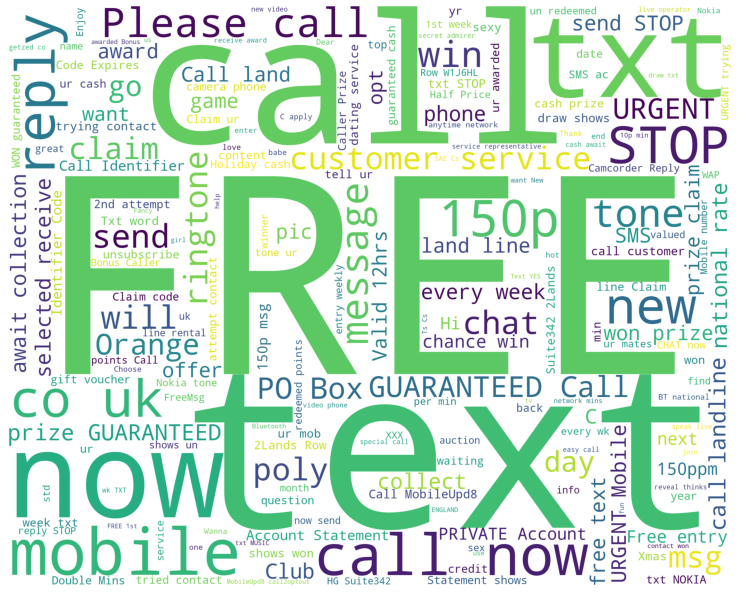

ham words


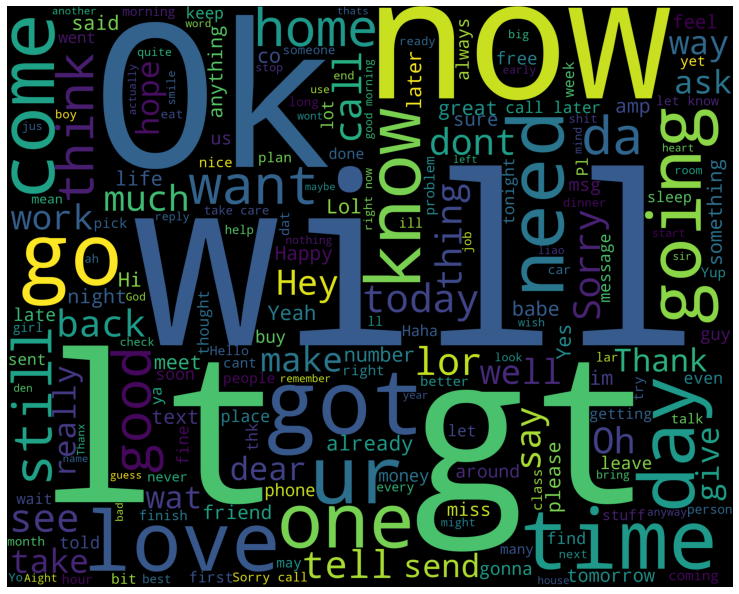

In [6]:
#wordcloud

train_spam = data[data['v1'] == 'spam'] #train_pos contains only spam data
train_spam = train_spam['v2'] 
train_ham = data[data['v1'] == 'ham'] #train_neg conatins only ham data
train_ham = train_ham['v2']

#creating a wordcloud_plot function for printing the key words in both positive and negative sentiment
def wordcloud_plot(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()]) #splitting the text into words                      
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

    
print("Spam words")
wordcloud_plot(train_spam,'white')  #Printing the wordcloud plot for spam words
print("ham words")
wordcloud_plot(train_ham) #pritnting the wordcloud plot for ham words

In [7]:
#pre-processing the text data
data['v2'] = data['v2'].apply(lambda x: x.lower()) #lowers all the characters
data['v2'] = data['v2'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x))) #removes special characters

In [8]:
#Tokenization
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ') #splitting the texts into tokens
tokenizer.fit_on_texts(data['v2'].values)
X = tokenizer.texts_to_sequences(data['v2'].values) #converting the texts to sequences

In [9]:
X = pad_sequences(X) #padding the sequences

In [10]:
embed_dim = 128
lstm_out = 196
def createmodel():  #createmodel 
    model = Sequential() 
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1])) #passing parameters
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)) #adding one more layer with LSTM
    model.add(Dense(2,activation='softmax')) #output layer
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [11]:
labelencoder = LabelEncoder() #labelENcoder
integer_encoded = labelencoder.fit_transform(data['v1']) #fitting the data to the labelencoder
y = to_categorical(integer_encoded) 
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42) #splitting the data into train and test

In [12]:
#printting the shapes of train and test data
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3733, 152) (3733, 2)
(1839, 152) (1839, 2)


In [13]:
batch_size = 40
model = createmodel()
history = model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2) #fitting the model
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size) #finding loss and accuracy of model
print('Score    : ' ,score)
print('Accuracy : ' ,acc)
print(model.metrics_names)

94/94 - 34s - loss: 0.1805 - accuracy: 0.9376
46/46 - 3s - loss: 0.0719 - accuracy: 0.9788
Score    :  0.07194996625185013
Accuracy :  0.9787928462028503
['loss', 'accuracy']


#### Observations :
1. Score of the model is 7%
2. Accuracy of the model is 97%

In [25]:
#Validating the data
validation_size = 1500
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:] 

In [28]:
ham_content, spam_content, ham_mail, spam_mail = 0, 0, 0, 0 #taking all the TP,TF,FP,FN values
for x in range(len(X_validate)): #creating a function for validating the tweet prediction accuracy
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0] #predicting the tweet
    
    if np.argmax(result) == np.argmax(Y_validate[x]): #comparing to their original
        if np.argmax(Y_validate[x]) == 0: 
            spam_mail += 1 
        else:
            ham_mail += 1
       
    if np.argmax(Y_validate[x]) == 0:
        spam_content += 1
    else:
        ham_content += 1


print("Ham mail accuracy : ", ham_mail/ham_content*100, "%")
print("Spam mail accuracy : ", spam_mail/spam_content*100, "%")

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1